# Scraping dati per creazione dataset

### Ricaviamo i dettagli tecnici di ogni versione di ogni modello di ogni marca di auto

##### import librerie

In [7]:
import asyncio
import aiohttp
from bs4 import BeautifulSoup
import json
from tqdm import tqdm
import re

##### Creazione classe per scrape html

In [8]:
class ScrapeGenerator:
    def __init__(self, url):
        self.url = url
        self.soup = None

    async def scrape_data(self):
            headers = {
                "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/58.0.3029.110 Safari/537.3",
            }
            async with aiohttp.ClientSession() as session:
                async with session.get(self.url,headers=headers) as response:
                    content = await response.text()
                    soup = BeautifulSoup(content, 'html.parser')
                    self.soup = soup
                    return soup

##### Funzione per prendere i modelli in produzione di ogni marca di auto

In [9]:
async def scrape_car_brand_data(sp: BeautifulSoup):
    # lista quantita auto in produzione
    bi = [y.text for y in sp.find_all('b',{'class':'col-green2'})]
    #trova tutti gli h5 che contengono gli 'a' con href al modello
    sp = sp.find_all('h5')
    all_brands_links = []
    for x in tqdm(range(len(sp)),"scraping car brand data"):
        if bi[x] == '0':
            continue
        #aggiungi tutti i link che hanno modelli in production
        all_brands_links.append(sp[x].find('a',href=True)['href'])

    return all_brands_links

##### Funzione per ricavare i modelli di ogni marca

In [10]:
def isPresent(l: list):
    for x in l:
        if "present" in str(x).lower():
            return True
def removeBrandName(s: str, torem: str):
    if "-" in torem:
        torem = torem.replace("-"," ")
    return s.replace(torem,"").strip()

async def scrape_car_model_data(lstBrand: list):
    ret = {} #{ brand:{model:{..info}}, ...  }
    for link_brand in tqdm(lstBrand,"scraping car models"):
        nme = link_brand.split("/")[3]
        sg = ScrapeGenerator(link_brand)
        sg = await sg.scrape_data()
        imglink = sg.find_all('div',{'class':'pic'})
        imglink = imglink[0].find('img')['src']
        ret[nme] = {'imglink':imglink}
        divCars = sg.find_all('div',{'class':'carmod clearfix'})
        #prendo ogni div che contiene ogni macchina
        for car in divCars:
            isPrnt = isPresent(car.find_all('span'))
            if not isPrnt:
                continue
            #se e' ancora in production aggiungiamo il link alla lista
            mname = removeBrandName(car.h4.text, nme.upper())
            lnk = car.a['href']
            ret[nme][mname] = {'link':lnk}

    return ret

##### Funzione per ricavare ogni modello di auto

In [11]:
def getEngines(divvoneCar: BeautifulSoup, brand: str, model: str):
    boxEngines = divvoneCar.find_all('div',{'class':'mot clearfix'})
    eng = {}
    for x in boxEngines:
        for y in x.find_all('a'):
            eng[y.text] = {'link':y['href']}
    return eng
    
async def scrape_eachModel_data(dizModels: dict):
    for brand in tqdm(dizModels.keys(),f"scraping models details"):
        for model in dizModels[brand]:
            if model == "imglink": continue
            sg = ScrapeGenerator(dizModels[brand][model]['link'])
            sg = await sg.scrape_data()
            
            imgcar = sg.find('div',{'class':'col1width fl'})
            imgcar = imgcar.find('img')['src']
        
            divEngines = sg.find_all('div',{'class':'container carmodel clearfix'})
            engList = getEngines(divEngines[0],brand,model)
            dizModels[brand][model]['engines'] = engList
            dizModels[brand][model]['car_imglink'] = imgcar

    return dizModels

##### Funzione per ricavare i dettagli di ogni versione di ogni modello

In [12]:
async def scrape_eachEngine_data(dizModels: dict):
    for brand in tqdm(dizModels.keys(),f"scraping engines details"):
        for model in dizModels[brand]:
            if model == "imglink": continue
            for engine in dizModels[brand][model]['engines']:
                sg = ScrapeGenerator(dizModels[brand][model]['engines'][engine]['link'])#['link']
                sg = await sg.scrape_data()
                tableInfo = sg.find_all('div',{'class':'padcol2'})
                for y in tableInfo:
                    if "ENGINE SPECS" in y.text:
                        tableInfo = y
                        break
                try:
                    descInfo = tableInfo.find_all('td',{'class':'left'})
                    descVal = tableInfo.find_all('td',{'class':'right'})
                except:
                    print(f"{tableInfo}")

                pattern = r'\((\d+)\sHP\)'
                match = re.search(pattern, engine)
                if match:
                    dizModels[brand][model]['engines'][engine]["HP"] = match.group(1)
                else:
                    dizModels[brand][model]['engines'][engine]["HP"] = None
                
                pattern = r'\d+(?:\.\d+)?(?:cc|L)'
                match = re.search(pattern, engine)
                if match:
                    dizModels[brand][model]['engines'][engine]["Pdisplacement"] = match.group(0)
                else:
                    dizModels[brand][model]['engines'][engine]["Pdisplacement"] = None

                for x in range(len(descInfo)):
                    dizModels[brand][model]['engines'][engine][descInfo[x].text] = descVal[x].text.strip()
    with open('completo.json', 'w') as f:
        json.dump(dizModels, f)
    return dizModels

##### Funzione principale che esegue i vari passaggi

In [ ]:
async def main(url):
    sg = ScrapeGenerator(url)
    sg = await sg.scrape_data()
    lbrand = await scrape_car_brand_data(sg)
    dcarModel = await scrape_car_model_data(lbrand)
    eachModelData = await scrape_eachModel_data(dcarModel)
    scrape_eachEngine_data(eachModelData)

if __name__ == '__main__':
    url = "https://www.autoevolution.com/cars/"
    asyncio.run(main(url))

### Ricaviamo i prezzi tramite ricerca google e scraping del risultato

##### Import librerie

In [3]:
import json
import asyncio
import re
from tqdm import tqdm
from selenium import webdriver
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.common.by import By

##### Iniziliziamo variabili globali e set delle opzioni dei webdriver di chrome

In [4]:
chrome_driver_path = "/usr/bin/google-chrome"
pathFile = "Datasets_Scraping/completo_wPrices_official.json"
pathInitFile = "Datasets_Scraping/completo.json"
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.binary_location = chrome_driver_path

##### Cerchiamo nell html della pagina della ricerca di google un prezzo coerente tramite regex 

In [16]:
def convert_to_integer(number_str):
    number_str =  number_str.replace("USD","").replace("$","").replace("EUR","").replace("€","").replace("£","").replace(" ","").strip()
    pattern = r'\.\d{2}$' 
    pattern2 = r',\d{2}$'  
    if re.search(pattern, number_str):
        number_str = number_str.split(".")[0]
    elif re.search(pattern2, number_str):
        number_str = number_str.split(",")[0]
    return int(number_str.replace(',', '').replace('.', ''))

async def seleniumscrape(link):
    browser = webdriver.Chrome(options=chrome_options)
    browser.get(link)
    acc = WebDriverWait(browser, 100).until(EC.element_to_be_clickable((By.XPATH, "//button[@id='L2AGLb']")))
    acc.click()
    element = WebDriverWait(browser, 10).until(EC.visibility_of_element_located((By.XPATH, "//div[@class='main']")))

    reg = r'((?:\$|€|USD)\s*\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?|\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?\$|\d{1,3}(?:[.,]\d{3})*(?:[.,]\d{2})?\s*(?:\$|€|USD))' #TODO check if regex works, added ?
    fnda = re.findall(reg, element.text) 
    numbers = []
    try:
        for num in fnda:
            numbers.append(convert_to_integer(num))
        max_number = max(numbers)
        if max_number > 20000000:
            numbers.remove(max_number)
            max_number = max(numbers)
        elif max_number < 2000:
            max_number = 0
    except Exception as e:
        max_number = 0
        print(f"error \n{e}\nON {link}")
    finally:
        browser.quit()
    return max_number

##### Funzione principale che esegue i vari passaggi

In [ ]:
async def main():
    with open(pathInitFile, 'r') as f:
        dcarModel = json.load(f)
        for x in tqdm(dcarModel, f"scraping prices"):
            for y in dcarModel[x]:
                if y == "imglink": continue
                lnk = f'https://www.google.com/search?q={x}+{y}+price'
                pricez = await seleniumscrape(lnk)
                dcarModel[x][y]['price'] = pricez
        with open(pathFile, 'w') as f:
            json.dump(dcarModel, f)
            
asyncio.run(main())

### Puliamo i dati del dataset

##### Import librerie

In [ ]:
import json
from tqdm import tqdm
import copy

##### Iniziliziamo variabili globali

In [ ]:
pathFile = "Datasets_Scraping/completo_wPrices_cleaner_official.json"
pathInitFile = "Datasets_Scraping/completo_wPrices_official.json"

##### Puliamo il dataset

In [ ]:
def cleanDs():
    with open(pathInitFile, 'r') as f:
        dcarModel = json.load(f)
        dcarModel_cln = copy.deepcopy(dcarModel)
        deletatiByCilindr = 0
        deletatiByEng = 0
        deletatiByPrc = 0
        for brand in tqdm(dcarModel.keys()):
            for model in dcarModel[brand].keys():
                if model == 'imglink': continue
                a = dcarModel[brand][model]
                if a['price'] == 0:
                    del dcarModel_cln[brand][model]
                    deletatiByPrc += 1
                    continue
                
                if len(a['engines'].keys()) == 0:
                    print("cancello [eng == 0]",brand, model)
                    del dcarModel_cln[brand][model]
                    deletatiByEng += 1
                    continue
                for eng in a['engines'].keys():
                    if len(a['engines'][eng].keys()) <3:
                        print("cancello [eng < 3]",brand, model, eng)
                        del dcarModel_cln[brand][model]['engines'][eng]
                        deletatiByEng += 1
                        continue
                
                    disp = a['engines'][eng].get('Displacement:')
                    pdisp = a['engines'][eng].get('Pdisplacement')
                    if disp == None and pdisp == None:
                        print("cancello [no cilindr info]",brand, model, eng)
                        del dcarModel_cln[brand][model]['engines'][eng]
                        deletatiByCilindr += 1
                    elif pdisp == None and disp:
                        numz =  "{:.1f}".format(int(disp.split()[0])/1000) 
                        dcarModel_cln[brand][model]['engines'][eng]['Pdisplacement'] = f"{numz}L"
                        
                if len(dcarModel_cln[brand][model]['engines'].keys()) == 0:
                    print("cancello [eng == 0]",brand, model)
                    del dcarModel_cln[brand][model]
                    deletatiByEng += 1
                    continue
                
        print("cancellatiByEngine", deletatiByEng)
        print("cancellatiByCilindri", deletatiByCilindr)
        print("cancellatiByPrezzo", deletatiByPrc)
                    
    with open(pathFile, 'w') as f:
        json.dump(dcarModel_cln, f)

if __name__ == '__main__':    
    cleanDs()

# Analisi dei dati

### Cerchiamo correlazioni tra i dati che consentano di fare previsioni

##### Import librerie

In [1]:
!pip install pandas
!pip install matplotlib
!pip install seaborn
!pip install scikit-learn


[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip



[notice] A new release of pip is available: 23.2.1 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.metrics import r2_score

### Import dati e creazione dataframe

##### Per comodità espositiva di questo notebook abbiamo creato un csv a partire dai dati inseriti nel database

In [3]:
df = pd.read_csv('Dati_auto.csv')

# Controlliamo l'eventuale presenza di valori "nan"

df.info()

# Non ci sono valori nan ma alcuni valori numerici sono "object" invece che "int" o "float". Provvediamo a risolvere:

df['prezzo'] = pd.to_numeric(df['prezzo'])
df['cavalli'] = pd.to_numeric(df['cavalli'])
df['cilindrata'] = pd.to_numeric(df['cilindrata'])
df['consumi'] = pd.to_numeric(df['consumi'])
df['emissioni'] = pd.to_numeric(df['emissioni'])
df['potenza'] = pd.to_numeric(df['potenza'])
df['serbatoio'] = pd.to_numeric(df['serbatoio'])

# Restano due campi non numerici che non avranno effetto nel misurare la correlazione con una regressione lineare,
# quindi eliminiamo queste due colonne

df = df.drop(['nome', 'carburante'], axis=1)

# Infine notiamo che i dati hanno unità di misura diverse e scale assai differenti, decidiamo quindi di normalizzarli

colonne = df.columns
scaler = StandardScaler()
data = scaler.fit_transform(df)
df = pd.DataFrame(data, columns=colonne)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 0 to 3003
Data columns (total 9 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   prezzo      3004 non-null   float64
 1   nome        3004 non-null   object 
 2   carburante  3004 non-null   object 
 3   cavalli     3004 non-null   int64  
 4   cilindrata  3004 non-null   float64
 5   consumi     3004 non-null   float64
 6   emissioni   3004 non-null   float64
 7   potenza     3004 non-null   float64
 8   serbatoio   3004 non-null   float64
dtypes: float64(6), int64(1), object(2)
memory usage: 211.3+ KB


### Data visualization

##### Prima di vedere le correlazioni analizziamo i dati da un punto di vista visivo tramite grafici delle librerie matplotlib e seaborn

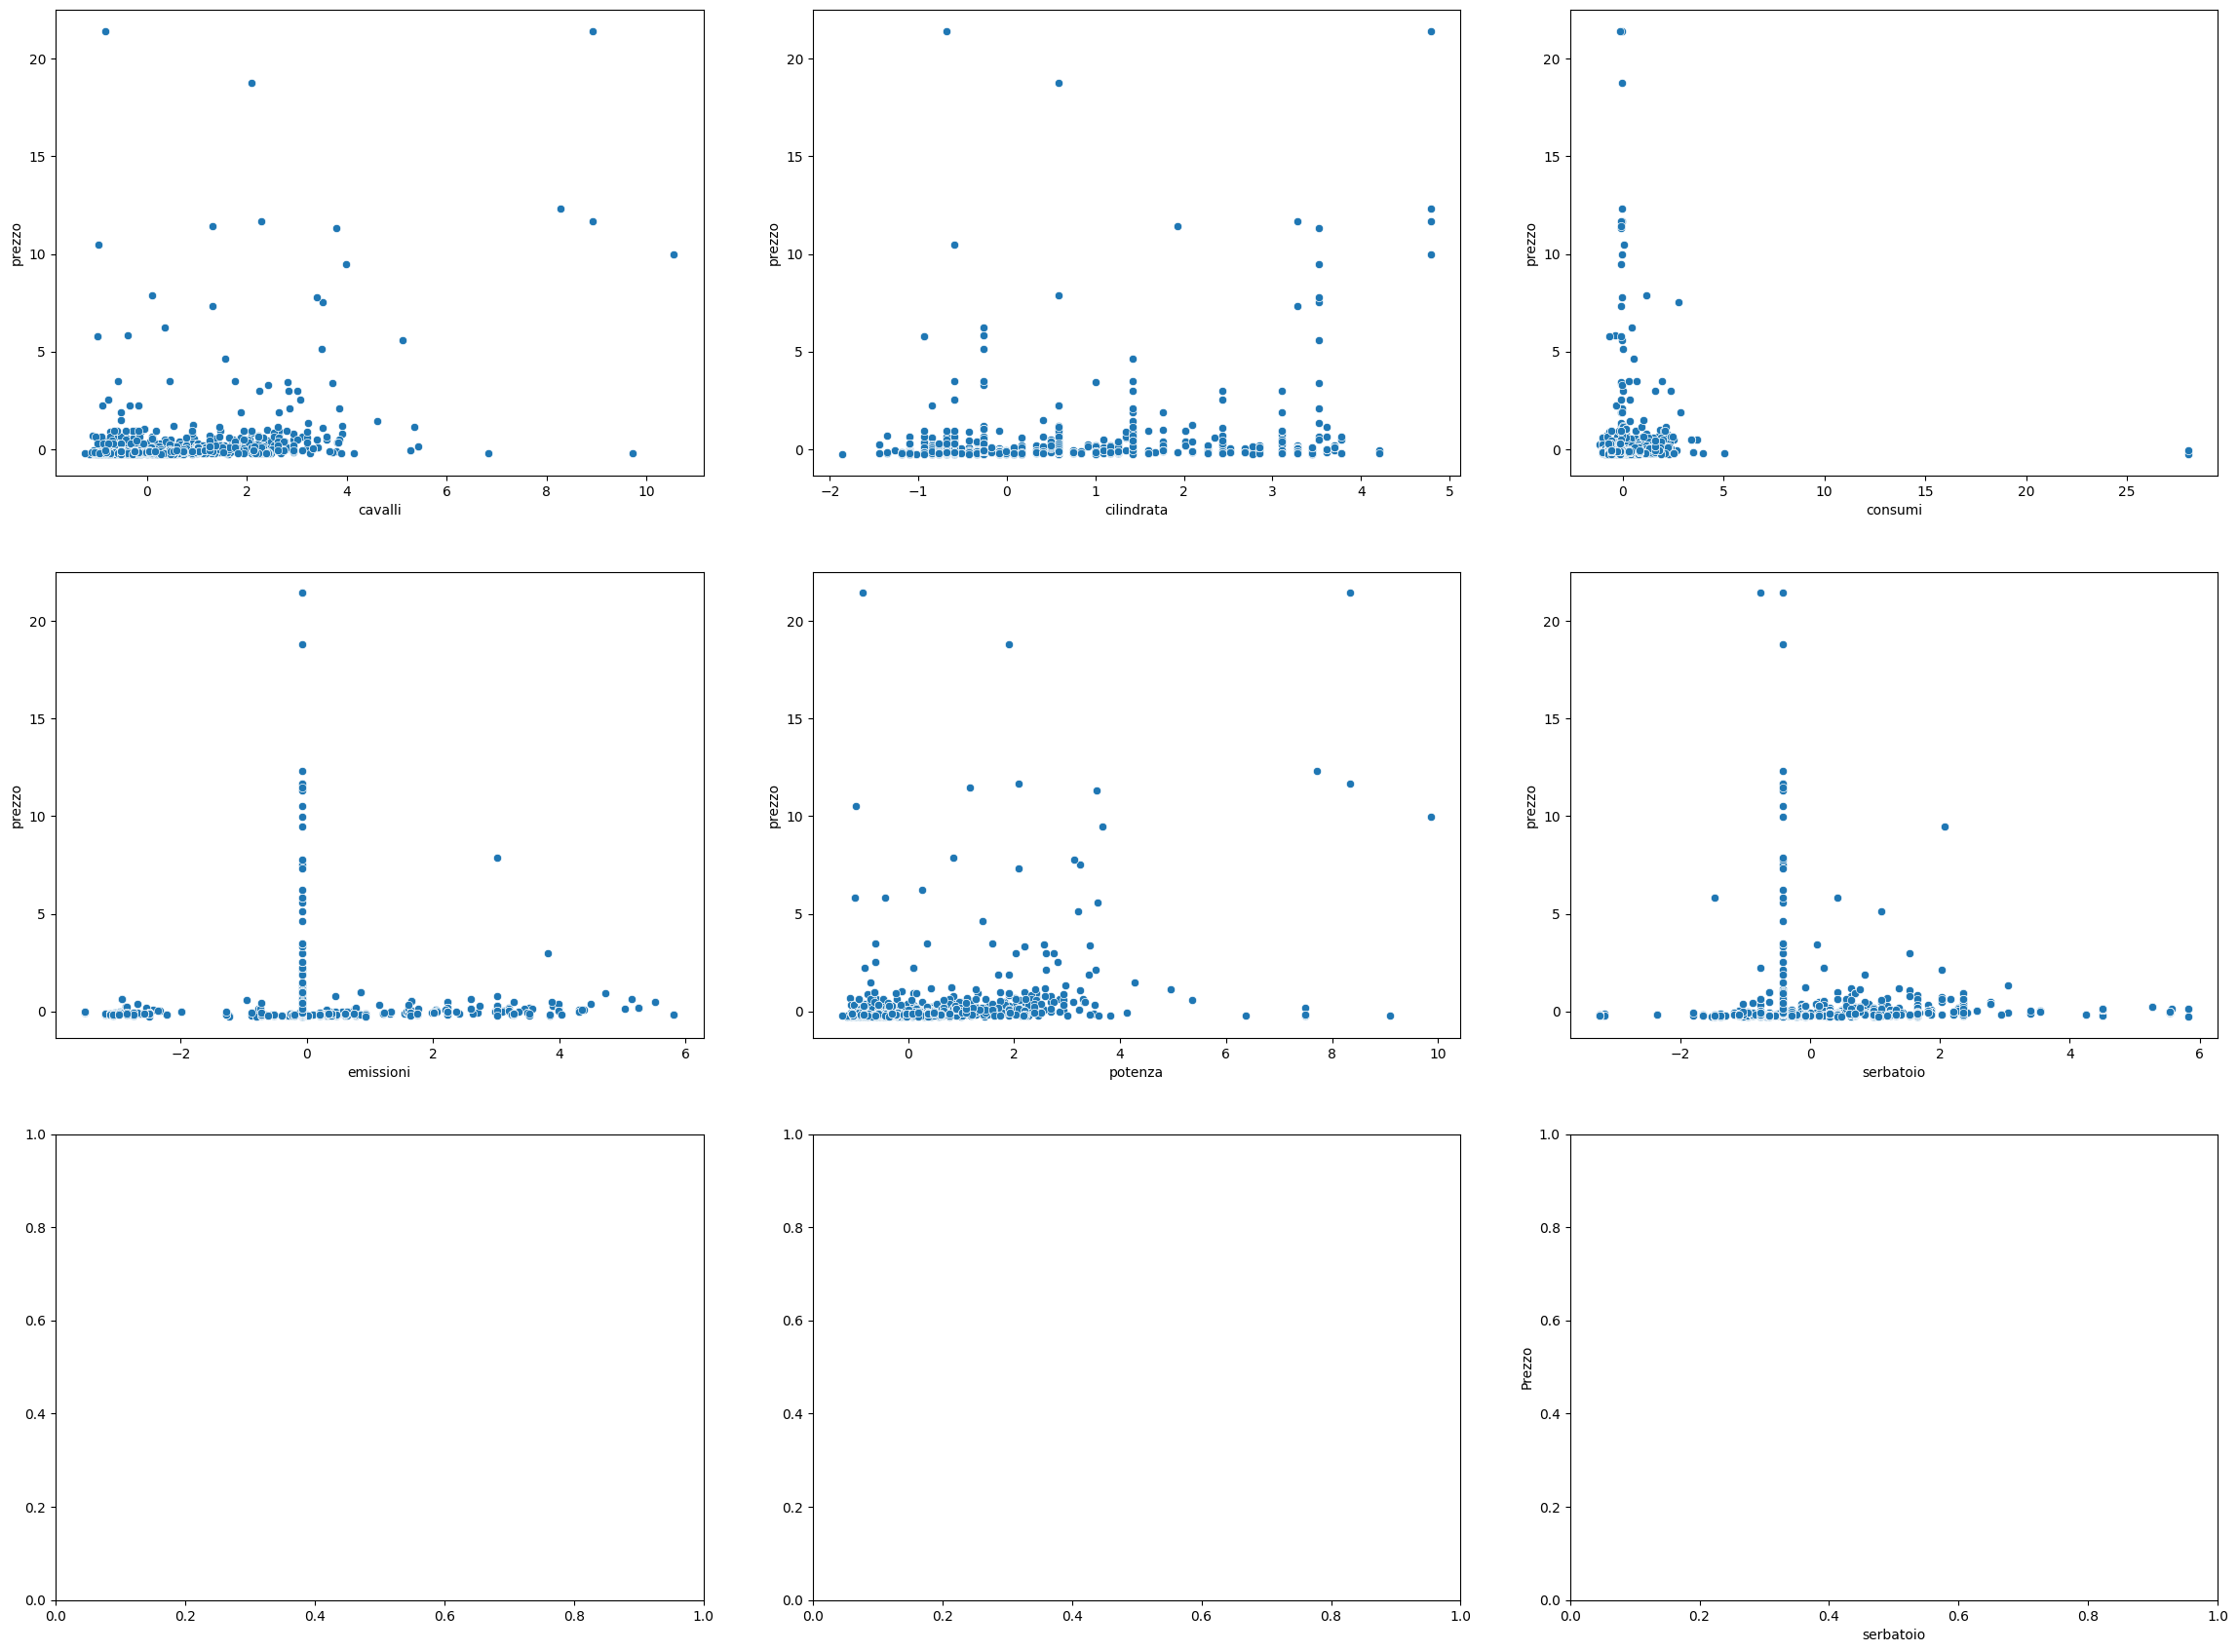

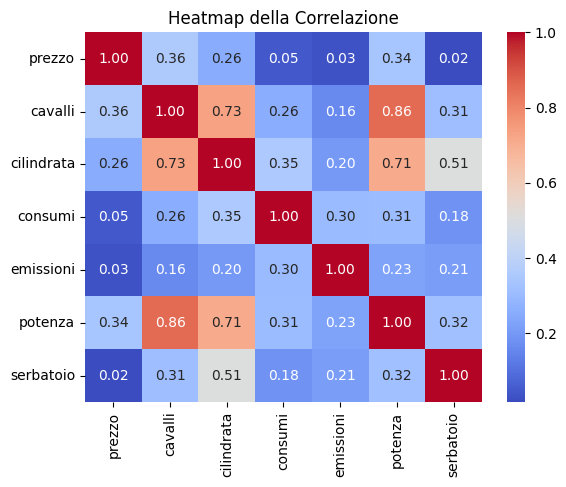

In [4]:
# Iniziamo con una serie di scatterplot che mostrino le relazioni tra il prezzo e ciascuna delle altre variabili

fig, axes = plt.subplots(3,3 , figsize=(24,18))
fig.tight_layout(pad=5.0)
axes = axes.flatten()
features = df.columns[1:]
for i in range(len(features)):
    sns.scatterplot(data=df, x=features[i], y="prezzo", ax=axes[i])
    plt.xlabel(str(features[i]))
    plt.ylabel('Prezzo')
plt.show()

# Notiamo da subito che i dati appaiono abbastanza sparsi e disordinati sul piano. Già da qui possiamo inferire che ci sia un
# basso indice di correlazione, ma ce ne sinceriamo con una heatmap:

correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap della Correlazione')
plt.show()

# La heatmap conferma i nostri sospetti mostrando indici di correlazione davvero bassi.

### Regressione Lineare

##### Tentiamo ora di applicare i modelli di regressione lineare di scikit learn

In [7]:
# Creiamo le variabili target e training e attraverso train_test_split generiamo le variabili per il training del modello e 
# quelle per il test

target = df['prezzo']
training = df.drop('prezzo', axis=1)
X_train, X_test, y_train, y_test = train_test_split(training, target, test_size=0.2, random_state=42)

# Ora istanziamo il modello di regressione lineare, lo addestriamo, facciamo delle predizioni e le visualizziamo insieme all'r^2

model = LinearRegression()
model.fit(X_train,y_train)
preds=model.predict(X_test)
preds
lineare = r2_score(y_test, preds)
print(f"L'r^2 score della regressione lineare è {lineare}")

# L'r^2 del modello lineare ha una bassissima bontà di adattamento ai dati

# Otteniamo risulati simili anche con altri modelli

# Decision Tree


model = DecisionTreeRegressor()
model.fit(X_train,y_train)
preds=model.predict(X_test)
albero = r2_score(y_test, preds)
print(f"L'r^2 score del Decision Tree è {albero}")

# Random Forest


model = RandomForestRegressor()
model.fit(X_train,y_train)
preds=model.predict(X_test)
foresta = r2_score(y_test, preds)
print(f"L'r^2 score della Random Forest è {foresta}")

# KNeighbors Regressor


model = KNeighborsRegressor(n_neighbors=2)
model.fit(X_train,y_train)
preds=model.predict(X_test)
vicino = r2_score(y_test, preds)
print(f"L'r^2 score della regressione KNeighbors è {vicino}")

L'r^2 score della regressione lineare è 0.18050678957373656
L'r^2 score del Decision Tree è -0.5998136809768047
L'r^2 score della Random Forest è 0.1501458389025706
L'r^2 score della regressione KNeighbors è 0.10541968740236518


### Funzione di regressione custom

##### A questo punto abbiamo pensato, dato che scikit learn usa algoritmi peculiari, di sviluppare una funzione per effettuare una regressione lineare come da statistica scolastica e verificare se cambiassero i risultati

In [8]:
# Funzione che prende due liste di training e una di test e restituisce la lista delle predizioni, la correlazione r e il 
#coefficiente di determinazione r^2
from statistics import mean
from math import sqrt, pow

def predittore(x_train, y_train, x_test): # Accetta solo liste di numeri
    if not isinstance(x_train, list):
        raise TypeError("Accetta solo una lista per x_train")
    if not isinstance(y_train, list):
        raise TypeError("Accetta solo una lista per y_train")
    if not isinstance(x_test, list):
        raise TypeError("Accetta solo una lista per x_test")
    for x in x_train:
        if not isinstance(x, (int, float)):
            raise TypeError("Ogni elemento di x_train deve essere un numero")
    for y in y_train:
        if not isinstance(y, (int, float)):
            raise TypeError("Ogni elemento deve di y_train essere un numero")
    for x in x_test:
        if not isinstance(x, (int, float)):
            raise TypeError("Ogni elemento deve di x_test essere un numero")
    x_medio = mean(x_train)
    y_medio = mean(y_train)
    lista_scarti_x = []
    lista_scarti_y = []
    for x in x_train:
        scarto = x - x_medio
        lista_scarti_x.append(scarto)
    for y in y_train:
        scarto = y - y_medio
        lista_scarti_y.append(scarto)
    prodotto_scarti = []
    for i in range(len(lista_scarti_x)):
        prodotto = lista_scarti_x[i] * lista_scarti_y[i]
        prodotto_scarti.append(prodotto)
    b = sum(prodotto_scarti)/pow(sum(lista_scarti_x), 2)
    a = y_medio - (b*x_medio)
    lista_predizioni = []
    for x in x_test:
        y = a + (b * x)
        lista_predizioni.append(y)
    quadrato_scarti_x = []
    quadrato_scarti_y = []
    for x in lista_scarti_x:
        quadrato = pow(x, 2)
        quadrato_scarti_x.append(quadrato)
    for y in lista_scarti_y:
        quadrato = pow(y, 2)
        quadrato_scarti_y.append(quadrato)
    s_x = sqrt((sum(quadrato_scarti_x)/(len(quadrato_scarti_x)-1)))
    s_y = sqrt((sum(quadrato_scarti_y)/(len(quadrato_scarti_y)-1)))
    r = (s_x / s_y) * b
    r = round(r)
    r_quadro = pow(r, 2)
    return [lista_predizioni, r, r_quadro]

In [11]:
# Dal dataframe estraiamo le liste dei prezzi e delle due variabili che correlano maggiormente (cavalli e potenza),
# le splittiamo per ottenere dati di training e dati di test e infine facciamo la regressione lineare

prezzo_y = df['prezzo'].tolist()
cavalli_x = df['cavalli'].tolist()
potenza_x = df['potenza'].tolist()


prezzo_y_train = prezzo_y[:int((0.8*len(prezzo_y)))]
prezzo_y_test = prezzo_y[int((0.8*len(prezzo_y))):]
cavalli_x_train = cavalli_x[:int(0.8 * len(cavalli_x))]
cavalli_x_test = cavalli_x[int(0.8 * len(cavalli_x)):]

print(predittore(cavalli_x_train, prezzo_y_train, cavalli_x_test)[1:])

potenza_x_train = potenza_x[:int(0.8 * len(potenza_x))]
potenza_x_test = potenza_x[int(0.8 * len(potenza_x)):]

print(predittore(potenza_x_train, prezzo_y_train, potenza_x_test)[1:])

# Sfortunatamente notiamo valori fuori scala e una correlazione insensata.

[10860058803285697495803967307776, 1.1794087721082317e+62]
[589389462420380823489506967552, 3.473799384121855e+59]


### Regressione polinomiale

##### Poiché tuttavia i nostri valori, come visto dai grafici, mal si adattano a una relazione lineare tentiamo come ultima spiaggia una regressione polinomiale

In [12]:
# importiamo il costruttore

from sklearn.preprocessing import PolynomialFeatures

In [13]:
# Utilizziamo una polinomiale di secondo grado per evitare l'overfitting

poly = PolynomialFeatures(degree=2, include_bias=False)
poly_features = poly.fit_transform(training)
X_train, X_test, y_train, y_test = train_test_split(poly_features, target, test_size=0.2, random_state=42)
poly_reg_model = LinearRegression()
poly_reg_model.fit(X_train, y_train)
poly_reg_y_predicted = poly_reg_model.predict(X_test)
print(r2_score(y_test, poly_reg_y_predicted))

# Il modello polinomiale è molto più efficiente, ma ci restituisce comunque un modello la cui bontà di adattamento è davvero
# bassa

0.3260932482289066


### Conclusioni

##### Nonostante i nostri sforzi non siamo riusciti a trovare correlazioni significative tra i dati che permettessero di predire i prezzi delle auto, dobbiamo dunque rassegnarci al fatto che l'idea di creare un modello di machine learning a partire dal nostro dataset è, in assenza di conoscenze di modelli più complessi, fortemente sconsigliata.

##### In ogni caso è il momento di costruire il nostro database e l'analisi dei dati fatta finora ci tornerà utile, ad esempio, per determinare i tipi di dati che stiamo trattando e tradurli nelle tipologie di MySQL.